<a href="https://colab.research.google.com/github/xAn-x/VisionLab/blob/master/VGG_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms as T

In [ ]:
transforms=T.Compose([
    T.ToTensor(),
    T.Normalize(0.5,0.7) # mean 0.5 and std 0.7
])

train_ds=FashionMNIST("./data",train=True,download=True,transform=transforms)
val_ds=FashionMNIST("./data",train=False,download=False,transform=transforms)

In [ ]:
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True,pin_memory=True,num_workers=2)
val_dl=DataLoader(val_ds,batch_size=128,shuffle=False,pin_memory=True,num_workers=2)


In [ ]:
print(f"No of batches in train_dl:{len(train_dl)}")
print(f"No of batches in val_dl:{len(val_dl)}")

No of batches in train_dl:938
No of batches in val_dl:79


In [ ]:
images,labels=next(iter(train_dl))

print(f"shape of an image: {images.shape[1:]}")

shape of an image: torch.Size([1, 28, 28])


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_batch(dl):
    # Get a batch of images
    images, labels = next(iter(dl))

    # Visualize the batch of images
    plt.figure(figsize=(16, 10))
    denorm_images=(images+0.5)*0.7
    plt.imshow(make_grid(denorm_images, nrow=8).permute(1, 2, 0))
    plt.axis('off')
    plt.show()

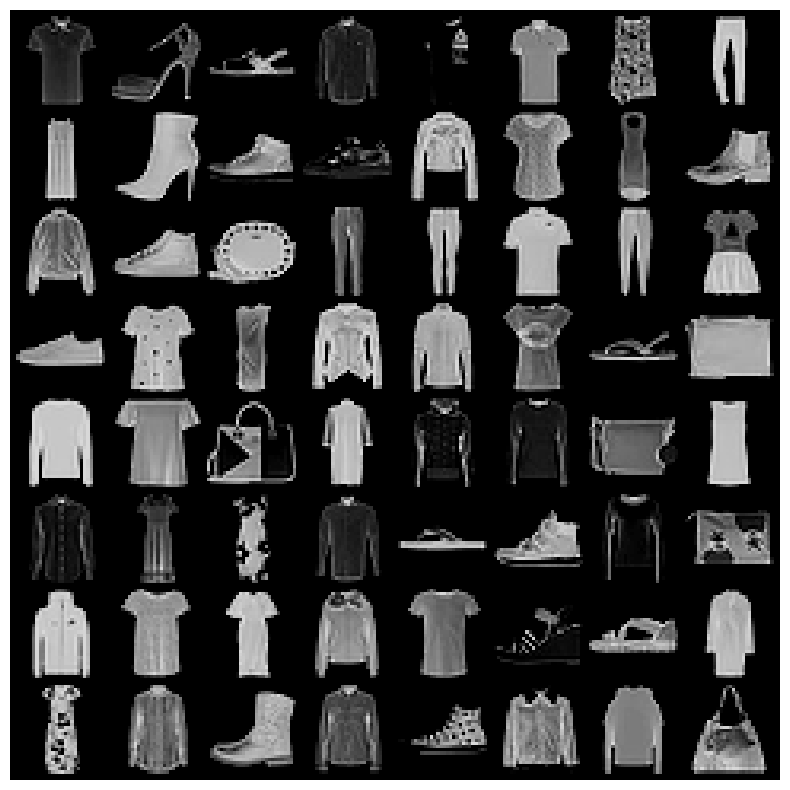

In [ ]:
visualize_batch(train_dl)

In [ ]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

### `VGG-16 Architecture`
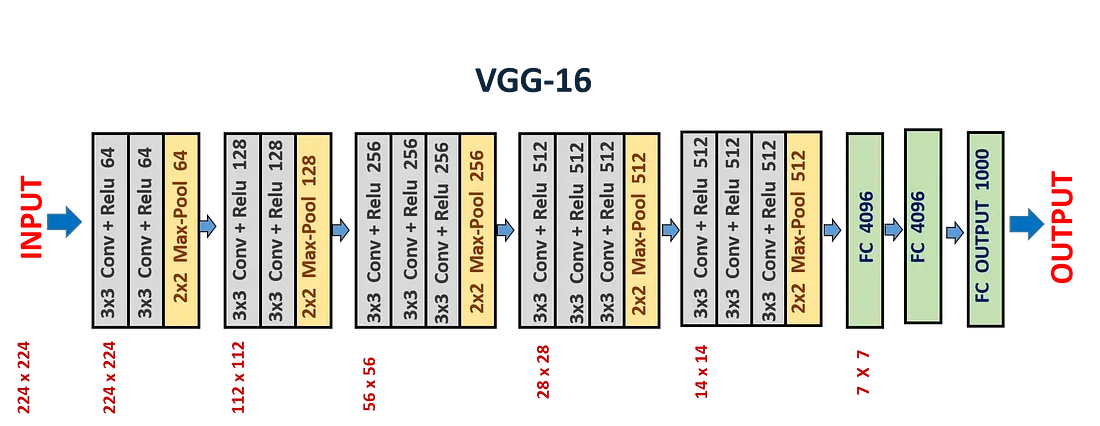

`NOTE:` The above vgg architecture is made for ImageNet dataset and will be overkilled for a simple-dataset like FashionMnist so I have tweeked the sizes.

In [ ]:
import torch.nn as nn

class VGG_NET(nn.Module):
  def __init__(self, in_channels, output_dims):
    super(VGG_NET, self).__init__()
    self.net = nn.Sequential(
      # Block-1
      nn.Conv2d(in_channels, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2)),

      # Block-2
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2)),

      # Block-3
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2)),

      # Block-4
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2)),

      # Feed-forward Net
      nn.Flatten(),
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, output_dims),
    )

  def forward(self, x):
    return self.net(x)


In [ ]:
model=VGG_NET(1,10).to(DEVICE)

model

VGG_NET(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(64, 128, kernel_size=(3, 3),

In [ ]:
x=torch.randn((1,1,28,28)).to(DEVICE)

model(x).shape

torch.Size([1, 10])

In [ ]:
import numpy as np

def train_model(model, train_dataloader, val_dataloader, epochs, device, optimizer, criterion):
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(epochs):
        model.train()
        total_correct_train = 0
        total_train_samples = 0
        total_train_loss = 0.0

        for batch in train_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels.view(-1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

        train_loss.append(total_train_loss / len(train_dataloader))
        train_accuracy.append(total_correct_train / total_train_samples)

        # Calculate validation accuracy after each epoch
        model.eval()
        with torch.no_grad():
            total_correct_val = 0
            total_val_samples = 0
            total_val_loss = 0.0
            for batch in val_dataloader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels.view(-1))

                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_correct_val += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

            val_loss.append(total_val_loss / len(val_dataloader))
            val_accuracy.append(total_correct_val / total_val_samples)

        print(f"Epoch: {epoch + 1}")
        print(f"Training Loss: {train_loss[-1]:.4f}")
        print(f"Training Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Validation Loss: {val_loss[-1]:.4f}")
        print(f"Validation Accuracy: {val_accuracy[-1]:.4f}\n")

    return {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy
    }

In [ ]:
# Define optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Assuming 'device' is defined earlier
# Train the model
hist = train_model(model, train_dl, val_dl, epochs=10, device=DEVICE, optimizer=optimizer, criterion=criterion)

Epoch: 1
Training Loss: 0.7620
Training Accuracy: 0.7087
Validation Loss: 0.5152
Validation Accuracy: 0.8092

Epoch: 2
Training Loss: 0.4174
Training Accuracy: 0.8477
Validation Loss: 0.3666
Validation Accuracy: 0.8682

Epoch: 3
Training Loss: 0.3300
Training Accuracy: 0.8793
Validation Loss: 0.3261
Validation Accuracy: 0.8847

Epoch: 4
Training Loss: 0.2849
Training Accuracy: 0.8969
Validation Loss: 0.3052
Validation Accuracy: 0.8858

Epoch: 5
Training Loss: 0.2570
Training Accuracy: 0.9080
Validation Loss: 0.2905
Validation Accuracy: 0.8953

Epoch: 6
Training Loss: 0.2356
Training Accuracy: 0.9139
Validation Loss: 0.2738
Validation Accuracy: 0.9038

Epoch: 7
Training Loss: 0.2199
Training Accuracy: 0.9203
Validation Loss: 0.2755
Validation Accuracy: 0.9003

Epoch: 8
Training Loss: 0.2049
Training Accuracy: 0.9266
Validation Loss: 0.2617
Validation Accuracy: 0.9084

Epoch: 9
Training Loss: 0.1888
Training Accuracy: 0.9309
Validation Loss: 0.2573
Validation Accuracy: 0.9093

Epoch: 10


In [ ]:
import matplotlib.pyplot as plt

def visualize_metric(hist, metric):
    plt.figure(figsize=(10, 6))

    plt.plot(hist[f"train_{metric}"], "r*-", label=f"Training {metric}")
    plt.plot(hist[f"val_{metric}"], "b*-", label=f"Validation {metric}")

    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"Training and Validation {metric.capitalize()}")

    plt.grid(True)

    plt.legend(loc="best", fancybox=True, shadow=True)

    plt.show()

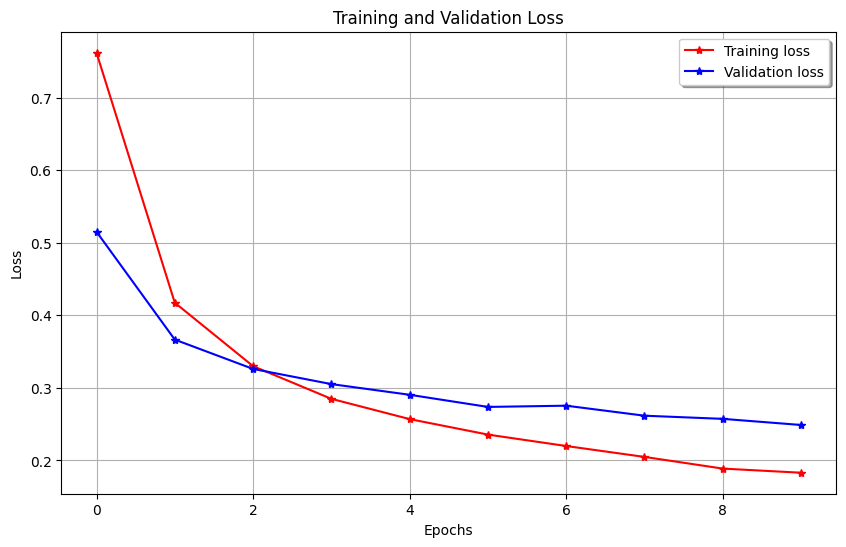

In [ ]:
visualize_metric(hist,"loss")

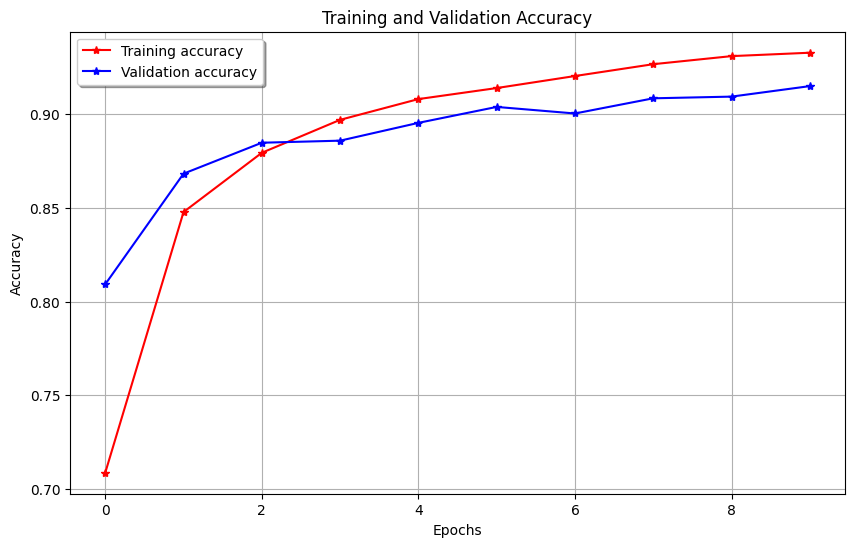

In [ ]:
visualize_metric(hist,"accuracy")

`There is no sign of overfitting`: we can train the model for some more epochs

To Improve performance we can even use
  - Data Augmentation
  - Implement some more advance architecture like GoogleNet or ResNet
  - Transfer Learning : using a state of the art model and then fine tune it over our dataset this generally yields better results